In [ ]:
!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alifrahman/chestxraydataset
!unzip chestxraydataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0419-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0420-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0421-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0423-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0424-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0425-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0427-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0428-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0429-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0429-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0429-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0430-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0431-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0432-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0433-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0434-0001.jpeg  
  inflating: chest_xray/tra

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
29084464/29084464 [==============================] - 2s 0us/step
Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Epoch 1/10
131/131 [==============================] - 88s 562ms/step - loss: 0.3421 - accuracy: 0.8991 - precision: 0.9320 - recall: 0.9317 - val_loss: 0.2340 - val_accuracy: 0.9272 - val_precision: 0.9837 - val_recall: 0.9187
Epoch 2/10
131/131 [==============================] - 67s 515ms/step - loss: 0.2207 - accuracy: 0.9183 - precision: 0.9438 - recall: 0.9459 - val_loss: 0.2305 - val_accuracy: 0.9301 - val_precision: 0.9864 - val_recall: 0.9199
Epoch 3/10
131/131 [==============================] - 68s 515ms/step - loss: 0.1763 - accuracy: 0.9365 - precision: 0.9572 - recall: 0.9569 - val_loss: 0.1616 - val_accuracy: 0.9435 - val_precision: 0.9919 - val_recall: 0.9327
Epoch 4/10
131/131 [=============================

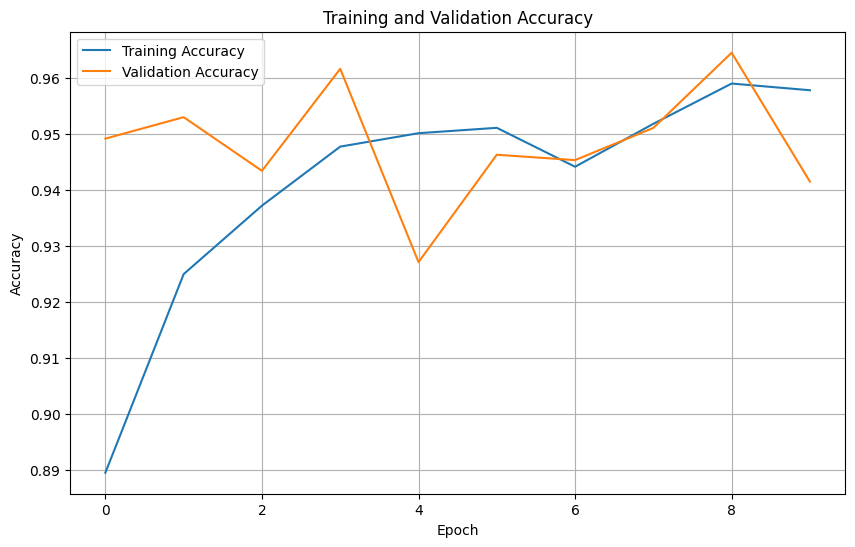

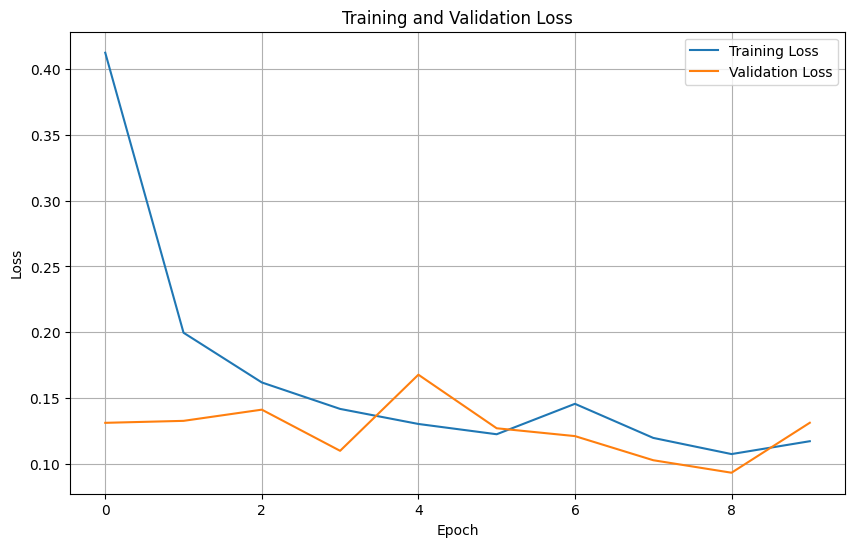

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os
import pandas as pd

# Define data paths and image size
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'
img_size = (150, 150)

# Define data generators for training and validation with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Load the pre-trained DenseNet121 model without the top layer
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Rename layers to avoid slashes in their names
for layer in densenet_base.layers:
    layer._name = layer.name.replace('/', '_')

# Freeze pre-trained layers for transfer learning
for layer in densenet_base.layers:
    layer.trainable = False

# Add custom layers for classification
def build_model():
    x = densenet_base.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=densenet_base.input, outputs=predictions)
    return model

# K-Fold Cross Validation setup
kfold = KFold(n_splits=5, shuffle=True)
folds_accuracy = []
folds_loss = []

best_fold_accuracy = 0
best_fold_model = None

# Get list of all file paths and labels
file_paths = []
labels = []
for cls in train_generator.class_indices.keys():
    class_dir = os.path.join(train_data_dir, cls)
    for file in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file))
        labels.append(train_generator.class_indices[cls])

file_paths = np.array(file_paths)
labels = np.array(labels)

# Loop through each fold
for train_index, val_index in kfold.split(file_paths, labels):
    # Split data into training and validation sets for the current fold
    train_files, val_files = file_paths[train_index], file_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Convert numeric labels to strings
    train_labels_str = train_labels.astype(str)
    val_labels_str = val_labels.astype(str)

    # Create data generators for the current fold
    train_fold_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels_str}),
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=32,
        class_mode='binary',
        shuffle=True)

    val_fold_generator = validation_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels_str}),
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=32,
        class_mode='binary',
        shuffle=False)

    # Create a new instance of the model for each fold
    model = build_model()
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    # Train the model on the current fold's training data
    history = model.fit(train_fold_generator, epochs=10, validation_data=val_fold_generator)

    # Evaluate the model on the current fold's validation data
    val_loss, val_acc, val_precision, val_recall = model.evaluate(val_fold_generator)

    # Save fold performance
    folds_accuracy.append(val_acc)
    folds_loss.append(val_loss)

    if val_acc > best_fold_accuracy:
        best_fold_accuracy = val_acc
        best_fold_model = model

# Print average performance across folds
print('Average Test Accuracy:', np.mean(folds_accuracy))
print('Average Test Loss:', np.mean(folds_loss))

# Plot training and validation curves for the last fold (as an example)
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.show()

# Save the best model
best_fold_model.save("best.h5")


In [ ]:
import pickle  # Import pickle library

with open('best_pneumonia_model.pkl', 'wb') as file:  # Open in binary write mode
    pickle.dump(best_fold_model, file)  # Pickle the best model

print('Saved best model to best_pneumonia_model.pkl')

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a separate directory containing test images
test_image_dir = "chest_xray/test/PNEUMONIA"

# Define a function to load and pre-process test images
def load_and_preprocess_image(img_path):
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = img_array / 255.0  # Rescale to [0, 1]
  return img_array

# Get the first two test image paths
test_image_paths = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir)]
top_2_paths = test_image_paths[:2]  # Limit to top 2 images

# Use the best performing model for prediction
predictions = best_fold_model.predict(np.array([load_and_preprocess_image(p) for p in top_2_paths]))

# Threshold for binary classification (adjust as needed)
prediction_threshold = 0.5

# Print predictions and display images for top 2 test images
for i, image_path in enumerate(top_2_paths):
  predicted_class = "Pneumonia" if predictions[i][0] > prediction_threshold else "Normal"
  print(f"Image: {image_path} - Predicted Class: {predicted_class}")

  # Load the image
  img = tf.keras.preprocessing.image.load_img(image_path)

  # Display the image
  plt.imshow(img)
  plt.title(f"{image_path.split('/')[-1]} - {predicted_class}")  # Show filename and prediction
  plt.axis('off')
  plt.show()
